This is a jupyter notebook on Digital Signal Processing, especially filters and windows

In [1]:
#%matplotlib notebook
import numpy as np
# import scipy.signal

import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
# from matplotlib.gridspec import GridSpec
# import matplotlib.ticker as ticker
print_context_dict ={'text.usetex':True,
                     'text.latex.preamble':"\\usepackage{siunitx}\n \\usepackage{xfrac}",
                     'font.size':10,
                     'legend.fontsize':10,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10,
                     'axes.labelsize':10,
                     'font.family':'serif',
                     'legend.labelspacing':0.1,
                     'axes.linewidth':0.5,
                     'xtick.major.width':0.2,
                     'ytick.major.width':0.2,
                     'xtick.major.width':0.5,
                     'ytick.major.width':0.5,
                     'figure.figsize':(5.906,5.906/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.906/2,5.906/2/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.53/2,2.96),#beamer
                     #'figure.figsize':(5.53/2*2,2.96*2),#beamer
                     'figure.dpi':100}
    #figsize=(5.53,2.96)#beamer 16:9
    #figsize=(3.69,2.96)#beamer 16:9
    #plot.rc('axes.formatter',use_locale=True) #german months
# must be manually set due to some matplotlib bugs
if print_context_dict['text.usetex']:
    plt.rc('text',usetex=True)
    plt.rc('text.latex',preamble="\\usepackage{siunitx}\n \\usepackage{xfrac}")


from sympy import *
import sympy.plotting.experimental_lambdify
init_printing()
def printM(expr, num_digits):
    return expr.xreplace({n.evalf() : round(n, num_digits) for n in expr.atoms(Number)})
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\sfrac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\sfrac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\sfrac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

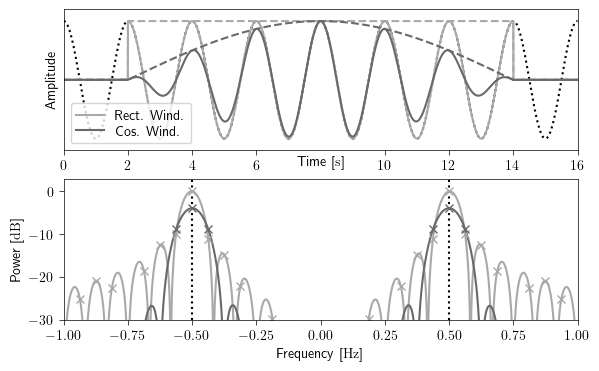

In [2]:
#%matplotlib notebook
#%matplotlib inline

power = lambda a: 10*np.log10(a**2)

dur=16#4*2*np.pi
N=4096
t=np.linspace(0,dur,N, endpoint=True)
dt=t[1]-t[0]
df=1/dur

num_cyc=8 # sine signal with xx cycles in dur
thisf=num_cyc*df 
thisT=1/thisf # period of sine signal
sin_sig=np.cos(thisf*2*np.pi*t)

win_len_cyc=6 # num_cyc/2
win_start=(num_cyc-win_len_cyc)/2*thisT
ind=int(win_start/dt) # index of end of cycle, where window starts
win_len=win_len_cyc*thisT

do_rect=True
do_cos=True

with matplotlib.rc_context(rc=print_context_dict):
    fig,[ax1,ax2]=plt.subplots(2,1)
#     _,[ax3,ax4] =plt.subplots(2,1, figsize=(5.906*2,5.906/1.618*2), sharex=True)
    
    ax1.plot(t,sin_sig, ls='dotted', color='black')
    if do_rect:
        rect_win=np.ones_like(sin_sig)
        rect_win[:ind+1]=0
        rect_win[-ind-1:]=0
        ax1.plot(t,sin_sig*rect_win, label='Rect. Wind.', color='darkgrey')
        ax1.plot(t,rect_win, ls='dashed', color='darkgrey')
    if do_cos:
        cos_win=np.sin(np.pi*(t-ind*dt)/win_len)
        cos_win[:ind+1]=0
        cos_win[-ind-1:]=0
    #     print(win[ind-1:-ind+1])
        ax1.plot(t,cos_win, ls='dashed', color='dimgrey')
        ax1.plot(t,cos_win*sin_sig, label='Cos. Wind.',color='dimgrey')
    
    ax1.set_yticks([])
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Time [\si{\second}]', backgroundcolor="white",labelpad=-12)
    #ax1.xaxis.set_major_locator(plt.MultipleLocator(2*np.pi))
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(0.5)))
    ax1.set_xlim((0,dur))
    ax1.set_ylim((-1.2,1.2))
    
    fftfreq = np.fft.fftfreq(N,dt)
    anafreq=np.linspace(-1,1,N,endpoint=True)

    ax2.axvline(thisf, color='black', ls='dotted')
    ax2.axvline(-thisf, color='black', ls='dotted')
    if do_rect:
        this_omegas=(anafreq-thisf)*2*np.pi
        spect_an=win_len*np.sin(this_omegas*win_len/2)/(this_omegas*win_len/2)*np.exp(-1j*this_omegas*win_len/2)
        spect_an=-1j/this_omegas+1j/this_omegas*np.exp(-1j*this_omegas*win_len)
        spect_an/=win_len
        
        this_omegas=(anafreq+thisf)*2*np.pi
        spect_an2=win_len*np.sin(this_omegas*win_len/2)/(this_omegas*win_len/2)*np.exp(-1j*this_omegas*win_len/2)
        spect_an2=-1j/this_omegas+1j/this_omegas*np.exp(-1j*this_omegas*win_len)
        spect_an2/=win_len
        
        ax2.plot(anafreq,power(np.abs(spect_an+spect_an2)), label='rect', color='darkgrey')
        #ax2.plot(anafreq,power(np.abs(1j*(spect_an+spect_an2))), color='blue')
#         ax3.plot(anafreq,np.abs(spect_an), label='rect', color='darkgrey')
#         ax3.plot(anafreq,np.abs(spect_an2), label='rect', color='black')
#         ax3.plot(anafreq,np.abs(spect_an+spect_an2), label='rect', color='blue')
#         ax4.plot(anafreq,np.angle(spect_an), label='rect', color='darkgrey')
#         ax4.plot(anafreq,np.angle(spect_an2), label='rect', color='black')
#         ax4.plot(anafreq,np.angle(spect_an+spect_an2), label='rect', color='blue')

    if do_cos:
        this_omegas=(anafreq-thisf)*2*np.pi
        spect_an=np.cos(this_omegas*win_len/2)*(win_len/(np.pi-this_omegas*win_len)+win_len/(np.pi+this_omegas*win_len))*np.exp(-1j*this_omegas*win_len/2)
        spect_an/=win_len
        
        this_omegas=(anafreq+thisf)*2*np.pi
        spect_an2=np.cos(this_omegas*win_len/2)*(win_len/(np.pi-this_omegas*win_len)+win_len/(np.pi+this_omegas*win_len))*np.exp(-1j*this_omegas*win_len/2)
        spect_an2/=win_len
        
        ax2.plot(anafreq,power(np.abs(spect_an+spect_an2)), label='cos',color='dimgrey')
    
    for do,fact,label,color in zip([do_rect,do_cos],[rect_win,cos_win],['rect','cos'],['darkgrey','dimgrey']):
        if do:
            fft=np.fft.fft(fact*sin_sig)*dt/win_len*2
            
            ax2.plot(fftfreq,power(np.abs(fft)),ls='none', marker='x', label=label,color=color)
            #ax3.plot(fftfreq,np.abs(fft),ls='none', marker='x', label=label,color=color)
            #ax4.plot(fftfreq,np.angle(fft),ls='none', marker='x', label=label,color=color)
            
#     ax3.set_xlim((-2*thisf,2*thisf))
    ax2.set_xlim((-2*thisf,2*thisf))
    ax2.set_ylim((-30,3))
    ax2.set_ylabel('Power [\si{\decibel}]')
    ax2.set_xlabel('Frequency [\si{\hertz}]')
    ax1.legend()
    fig.subplots_adjust(top=0.970,bottom=0.12,left=0.1, right=0.97,wspace=0.02,hspace=0.2)
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/example_window.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/example_window.png')


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


'\nContinue with:\n- Recursive formulation -> Impulse response (Step response) -> Frequency response\n- poles and zeros\n\n-convolve, lfilter, sosfilter (forward/backward)\n\ninverstigate:\n- Moving average Filter\n- custom filter\n- scipy filters \n\napply to example signal\n'

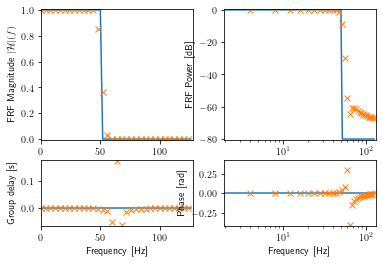

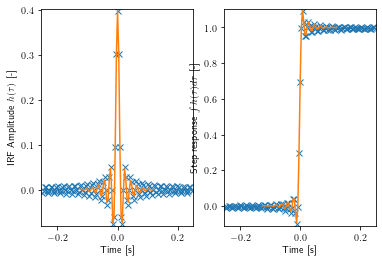

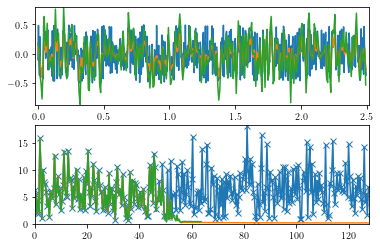

In [3]:
#%matplotlib notebook
#%matplotlib inline

'''
Example figure for step response(slow/fast, overshoot, phase) and frequency response (roll-off, ripple, attenuation)
'''
# 
#https://flylib.com/books/en/2.729.1/the_dft_of_rectangular_functions.html
#windowed-sinc aka. Dirichlet-Kernel

fs=256
N=128
df=fs/N
dur=1/df
dt=dur/N



fcl=50
fch=None

if fcl is not None:
    fcl=np.round(fcl/df)*df
if fch is not None:
    fch=np.round(fch/df)*df
    
if fcl is not None and fch is not None:
    if fcl < fch:print('band reject')
    if fcl> fch: print('band pass')

        
freq = np.linspace(-fs/2,fs/2,N,False)
assert df == freq[1]-freq[0]
freq = np.fft.fftfreq(N,dt)

if fcl is not None:
    frfl = np.zeros((N,))
    Kl=int(fcl/df)
    frfl[:Kl+1] = 1 # including sample K
    frfl[-Kl:] = 1

if fch is not None:
    frfh = np.zeros((N,))
    Kh=int(fch/df)
    frfh[Kh:-Kh+1] = 1
    
if fcl is not None and fch is not None:
    if fcl < fch:# band reject
        frf = frfh+frfl
    if fcl> fch: # band pass
        frf = frfh*frfl
elif fch is not None:
    frf=frfh
elif fcl is not None:
    frf=frfl
    

fig, axes = plt.subplots(2,2, sharex=False, gridspec_kw={'height_ratios':[2,1]})
(ax11,ax12,ax13,ax14) = axes.flat
ax11.plot(np.fft.fftshift(freq),np.fft.fftshift(np.abs(frf)))
angle = np.angle(frf)
angle[angle>np.pi/2]-=np.pi
angle[angle<-np.pi/2]+=np.pi
group_delay = -np.diff(angle,prepend=[0])/df
ax13.plot(np.fft.fftshift(freq),np.fft.fftshift(group_delay))
ax14.semilogx(np.fft.fftshift(freq),np.fft.fftshift(angle))
ax12.semilogx(np.fft.fftshift(freq),20*np.log10(np.fft.fftshift(np.abs(frf)+1e-4)))
irf = np.fft.ifft(frf)
if (np.imag(irf)>1e-16).any():
    print('Warning: complex IRF')
else:
    irf = np.real(irf)
irf=np.roll(irf, N//2)
tim = np.linspace(-dur/2,dur/2-dt,N)
n=np.linspace(-N//2,N//2-1,N)

#irf2 = np.sinc((2*fcl+df)*tim)*(2*fcl+df)
# Dirichlet Kernel aka aliased sinc function 
if fcl is not None:
    irf2l = 1/N*np.sin(np.pi*n*(2*Kl+1)/N)/np.sin(np.pi*n/N) # Number of 1s in the frf is 2*K+1 [-K...0...K]
    irf2l[n==0]=(2*Kl+1)/N # l'Hospital of sin((2k+1)t)/sin(t)
if fch is not None:
    #using spectral reversal
    Kh=(fs/2-fch)/df
    irf2h = 1/N*np.sin(np.pi*n*(2*Kh+1)/N)/np.sin(np.pi*n/N) # Number of 1s in the frf is 2*K+1 [-K...0...K]
    irf2h[n==0]=(2*Kh+1)/N # l'Hospital of sin((2k+1)t)/sin(t)
    irf2h[1::2]*=-1
if fcl is not None and fch is not None:
    if fcl < fch:# band reject
        irf2 = irf2h+irf2l
    if fcl> fch: # band pass
        irf2 = np.convolve(irf2h,irf2l)
        nN=irf2.shape[0]
        irf2=irf2[(nN-N)//2:-(nN-N)//2] # truncate excessive length due to convolution
elif fch is not None:
    irf2=irf2h
elif fcl is not None:
    irf2=irf2l
    


fig, (ax21,ax22)=plt.subplots(1,2, sharex=True)
ax21.plot(tim,irf, marker='x',ls='none')
#ax21.plot(tim,irf2)

ax22.plot(tim,np.cumsum(irf), marker='x',ls='none')
#ax22.plot(tim,np.cumsum(irf2))
#plt.xlim((-50,50))


irf_trunc = irf[N//4:-N//4]*np.hamming(N//2)
irf2_trunc = irf2[N//4:-N//4]*np.hamming(N//2)
tim_trunc = tim[N//4:-N//4]

# ax21.plot(tim_trunc,irf_trunc, marker='x')
ax21.plot(tim_trunc,irf2_trunc)
# ax22.plot(tim_trunc, np.cumsum(irf_trunc), marker='x')
ax22.plot(tim_trunc, np.cumsum(irf2_trunc))

dur_trunc = tim_trunc[-1]-tim_trunc[0]
df_trunc = 1/dur_trunc
frf_trunc = np.fft.fft(irf_trunc)

freq_trunc = np.fft.fftfreq(irf_trunc.shape[0], tim_trunc[1]-tim_trunc[0])
ax11.plot(np.fft.fftshift(freq_trunc),np.fft.fftshift(np.abs(frf_trunc)), ls='none', marker='x')
angle = np.angle(frf_trunc)
angle[angle>np.pi/2]-=np.pi
angle[angle<-np.pi/2]+=np.pi
group_delay = -np.diff(angle,prepend=[0])/df_trunc
ax13.plot(np.fft.fftshift(freq_trunc),np.fft.fftshift(group_delay), ls='none', marker='x')
ax14.semilogx(np.fft.fftshift(freq_trunc),np.fft.fftshift(angle), ls='none', marker='x')
ax12.semilogx(np.fft.fftshift(freq_trunc),np.fft.fftshift(20*np.log10(np.abs(frf_trunc))), ls='none', marker='x')


ax11.set_xlim((0,fs/2))
ax11.set_xlabel('Frequency [Hz]')
ax11.set_ylabel('FRF Magnitude $|\\mathcal{H}| (f) $')

#ax12.set_xlim((0,fs/2))
ax12.set_xlabel('Frequency [Hz]')
ax12.set_ylabel('FRF Power [dB]')

#ax14.set_xlim((0,fs/2))
ax14.set_xlabel('Frequency [Hz]')
ax14.set_ylabel('Phase [rad]')

ax13.set_xlim((0,fs/2))
ax13.set_xlabel('Frequency [Hz]')
ax13.set_ylabel('Group delay [s]')

ax21.set_xlabel('Time [s]')
ax21.set_ylabel('IRF Amplitude $h(\\tau)$ [-]')

ax22.set_xlabel('Time [s]')
ax22.set_ylabel('Step response $\\int h(\\tau) d \\tau$ [-]')






tmax=300/120 #120 common period of 40 Hz and 60 Hz signal
tmax=np.round(tmax/dt)*dt

t = np.linspace(0, tmax, int(tmax*fs), False)  # 1 second

# sinusoids
sig = np.sin(2*np.pi*20*t) + np.sin(2*np.pi*60*t)
#step
#sig=np.zeros_like(t)
#sig[100:]=1
#noise
sig=np.random.random((t.shape[0]))-0.5
fig, (ax31,ax32)=plt.subplots(2,1)
ax31.plot(t,sig)
win=1
#win=np.hamming(sig.shape[0])
ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(win*sig))), marker='x')

#irf_dur = irf_trunc.shape[0]*dt
#t_filt=np.linspace(t[0]-irf_dur/2, t[-1]+irf_dur/2-dt,int(tmax*fs+irf_trunc.shape[0]-1))

sig_filt = np.convolve(sig, irf_trunc)
nN=irf_trunc.shape[0]-1
sig_filt=sig_filt[nN//2+1:-nN//2+1] # truncate excessive length due to convolution
ax31.plot(t,sig_filt)
win=1
#win=np.hamming(sig_filt.shape[0])
ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(win*sig_filt))))

dec_fact=2
sig_dec=sig_filt[::dec_fact]*dec_fact
t_dec=t[::dec_fact]

ax31.plot(t_dec,sig_dec)
ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig_dec.shape[0],dt*dec_fact)),np.fft.fftshift(np.abs(np.fft.fft(win*sig_dec))))
ax32.set_xlim(xmin=0,xmax=fs/2)

'''
Continue with:
- Recursive formulation -> Impulse response (Step response) -> Frequency response
- poles and zeros

-convolve, lfilter, sosfilter (forward/backward)

inverstigate:
- Moving average Filter
- custom filter
- scipy filters 

apply to example signal
'''

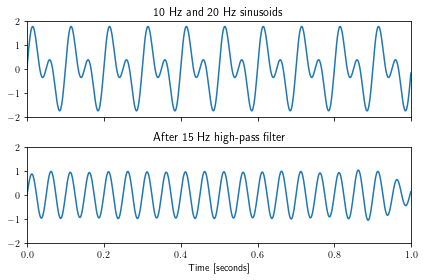

In [4]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
#sig+=2*np.random.random((1000,))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
if False:
    sos = signal.cheby1(6, 1, 15, 'hp', fs=1000, output='sos')
    filtered = signal.sosfiltfilt(sos, sig)
elif True:
    b,a = signal.cheby1(6, 1, 15, 'hp', fs=1000, output='ba')
    filtered = signal.filtfilt(b,a, sig)
else:
    b,a = signal.cheby1(6, 1, 15, 'hp', fs=1000, output='ba')
    filtered = signal.lfilter(b,a, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()


#### Tolerance scheme and flipped version

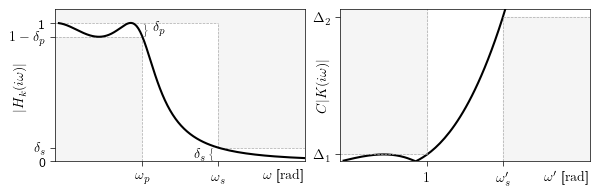

In [127]:


wp = 2.5
ws = 4.67481445
dP=0.1
dS=0.1

gpass = np.log10(1-dP)*(-20)
gstop = np.log10(dS)*(-20)

D1=np.sqrt(2*dP-dP**2)/(1-dP)
D2=np.sqrt(1-dS**2)/dS

system1 = signal.iirdesign(wp, ws, gpass, gstop,analog=True, ftype='cheby1')
system2 = signal.iirdesign(wp, ws, gpass, gstop,analog=True, ftype='cheby2')


fmax=ws+wp
with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(1,2, figsize=(5.906,5.906/1.618/2), sharex=False)
    
    #for system in (system1,system2):
    system=system1
    w, h = signal.freqs(*system)
    CKjw=np.sqrt(1/abs(h)**2-1)
    
    ymax=1.1
    ax1=axes[0]
    ax1.plot(w, abs(h), 'k')
    
    ax1.hlines(1-dP,0,wp, color='darkgrey',ls='dashed',lw=0.5)
    ax1.hlines(dS,ws,fmax, color='darkgrey',ls='dashed',lw=0.5)
    ax1.hlines(1,0,ws, color='darkgrey',ls='dashed',lw=0.5)    
    ax1.vlines(wp,0,1-dP, color='darkgrey',ls='dashed',lw=0.5)
    ax1.vlines(ws,dS,1, color='darkgrey',ls='dashed',lw=0.5)
    
    ax1.fill((0,wp,wp,0),(0,0,1-dP,1-dP), 'whitesmoke')
    ax1.fill((0,0,fmax,fmax,ws,ws),(1,ymax,ymax,dS,dS,1), 'whitesmoke')
    
    ax1.set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
    ax1.set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-11,loc='right')
    ax1.grid()
    ax1.set_xticks([wp,ws])
    ax1.set_xticklabels(['$\\omega_p$','$\\omega_s$'])

    ax1.set_yticks([0,dS,1-dP,1])
    ax1.set_yticklabels([0,'$\\delta_s$','$1-\\delta_p$',1])
    ax1.grid(0)
    ax1.set_ylim([0,ymax])
    ax1.annotate(r"$\}$",fontsize=10,xy=(wp, 0.925),color='dimgrey')
    ax1.annotate('$\\delta_p$',(wp+.3,0.94))

    ax1.annotate(r"$\{$",fontsize=10,xy=(ws-.3, 0.025),color='dimgrey')
    ax1.annotate('$\\delta_s$',(ws-.7,0.025))

    ax2=axes[1]    
    ax2.plot(w,CKjw, color='k')

    ymax=10.5
    ax2.axhline(D1,0,wp/fmax, color='darkgrey',ls='dashed',lw=0.5)
    ax2.axhline(D2,ws/fmax,1, color='darkgrey',ls='dashed',lw=0.5)
    ax2.axvline(wp,D1/ymax,1, color='darkgrey',ls='dashed',lw=0.5)
    ax2.axvline(ws,0,D2/ymax, color='darkgrey',ls='dashed',lw=0.5)
    
    ax2.fill((0,0,wp,wp),(D1,ymax,ymax,D1),color='whitesmoke')
    ax2.fill((ws,ws,fmax,fmax),(0,D2,D2,0),color='whitesmoke')

    ax2.set_ylabel('$C|K(i\\omega)|$',labelpad=-12)
    ax2.set_xlabel("$\\omega'$ [\\si{\\radian}]",labelpad=-11,loc='right')
    ax2.set_xticks([wp,ws])
    ax2.set_xticklabels(['$1$',"$\\omega'_s$"])
    ax2.set_yticks([D1,D2])
    ax2.set_yticklabels(['$\\Delta_1$',"$\\Delta_2$"])
    ax2.grid(0)
    ax2.set_ylim([0,ymax])

    ax2.set_xlim((0,fmax))
    ax1.set_xlim((0,fmax))
    fig.subplots_adjust(top=0.970,bottom=0.135,left=0.08, right=0.985, wspace=0.14,hspace=0.2)

    fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_specification.pdf')
    fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_specification.png')

### Butterworth filter: analytic and using scipy.signal

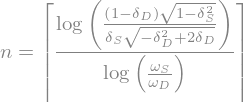

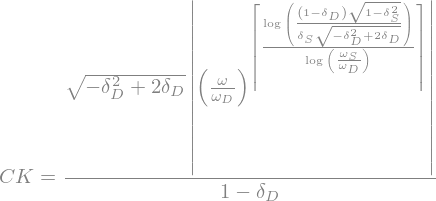

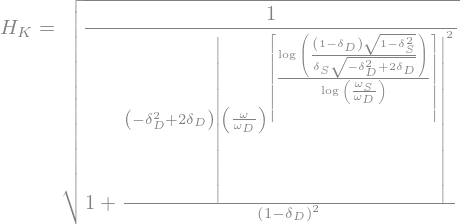

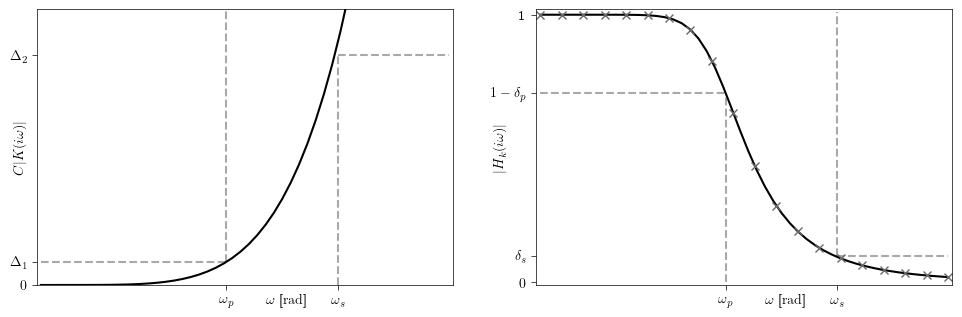

In [5]:
H,C,K,w,dD,dS,wD,wS,n=symbols('H_K C K \\omega \\delta_D \\delta_S \\omega_D \\omega_S n')
_H=1/(1+C**2*abs(K)**2)
wp=w/wD
wps=wS/wD

butterpol=wp**n

D1=sqrt(2*dD-dD**2)/(1-dD)
D2=sqrt(1-dS**2)/dS
n_=log(D2/D1,10)/log(wps,10) # convert to integer, even order not necessary
n_=ceiling(n_)
butter=sqrt(_H.subs(K,butterpol).subs(C,D1).subs(n,n_))

display(Eq(symbols('n'),n_))
display(Eq(C*K,D1*abs(butterpol.subs(n,n_))))
display(Eq(H,butter))



tolp=1-10**(-3/20)#0.1 #durchlassbereich
tols=0.1#sperrbereich
fp=20*2*np.pi
fs=32*2*np.pi

fun=(D1*abs(butterpol.subs(n,n_))).subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs)
fun=lambdify(w,fun)
fmax=2*fs+-fp
omegas = np.linspace(0,fmax)


with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(1,2, figsize=(5.906*2,5.906/1.618))
    axes[0].plot(omegas,fun(omegas),color='k')
    thisD1=float(D1.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
    thisD2=float(D2.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
    ymax=1.2*thisD2
    axes[0].set_ylim((0,ymax))
    axes[0].vlines(fp,thisD1,ymax, color='darkgrey',ls='dashed')
    axes[0].vlines(fs,0,thisD2, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD1,0,fp, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD2,fs,fmax, color='darkgrey',ls='dashed')
    axes[0].set_ylabel('$C|K(i\\omega)|$',labelpad=-12)
    axes[0].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[0].set_xticks([fp,fs])
    axes[0].set_xticklabels(['$\\omega_p$',"$\\omega_s$"])
    axes[0].set_yticks([0,thisD1,thisD2])
    axes[0].set_yticklabels(['$0$','$\\Delta_1$',"$\\Delta_2$"])

    gpass = np.log10(1-tolp)*(-20)
    gstop = np.log10(tols)*(-20)

    system = signal.iirdesign(fp, fs, gpass, gstop,analog=True, ftype='butter')
    omegas_, h = signal.freqs(*system,worN=np.linspace(0,fmax,20))


    fun=(butter.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
    fun=lambdify(w,fun)

    #fig,ax = plt.subplots()
    axes[1].plot(omegas,fun(omegas),color='k')
    axes[1].plot(omegas_,np.abs(h),ls='none',marker='x',color='dimgrey')
    ymax=axes[1].get_ylim()[1]
    axes[1].vlines(fp,0,(1-tolp), color='darkgrey',ls='dashed')
    axes[1].vlines(fs, tols,ymax, color='darkgrey',ls='dashed')
    axes[1].hlines(1-tolp,0,fp, color='darkgrey',ls='dashed')
    axes[1].hlines(tols,fs,fmax, color='darkgrey',ls='dashed')
    axes[1].set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
    axes[1].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[1].set_xticks([fp,fs])
    axes[1].set_xticklabels(['$\\omega_p$','$\\omega_s$'])
    axes[1].set_yticks([0,tols,1-tolp,1])
    axes[1].set_yticklabels(['$0$','$\\delta_s$',"$1-\\delta_p$",'1'])


order=float(n_.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
display(Eq(symbols('n'),order))
display(Eq(symbols('\\Delta_1'),thisD1))
display(Eq(symbols('\\Delta_2'),thisD2))


### Chebychev filter: analytic and using scipy.signal

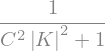

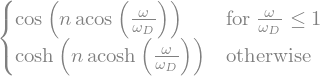

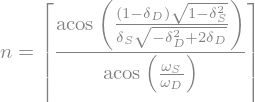

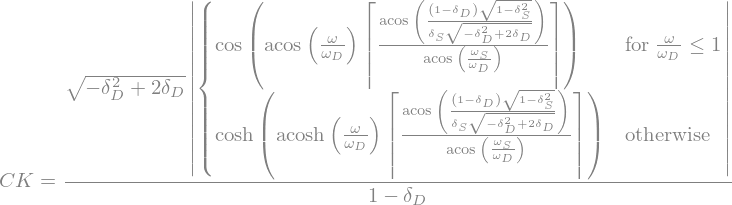

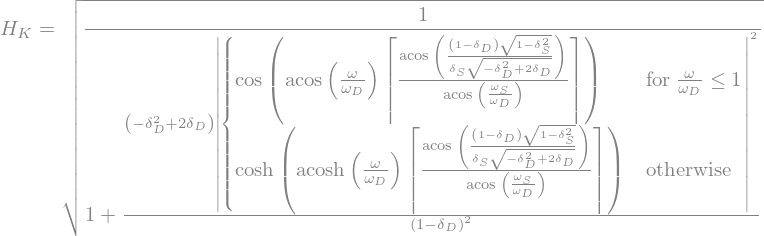

<string>:2: RuntimeWarning: invalid value encountered in arccos
<string>:2: RuntimeWarning: invalid value encountered in arccosh
<string>:2: RuntimeWarning: invalid value encountered in arccos
<string>:2: RuntimeWarning: invalid value encountered in arccosh


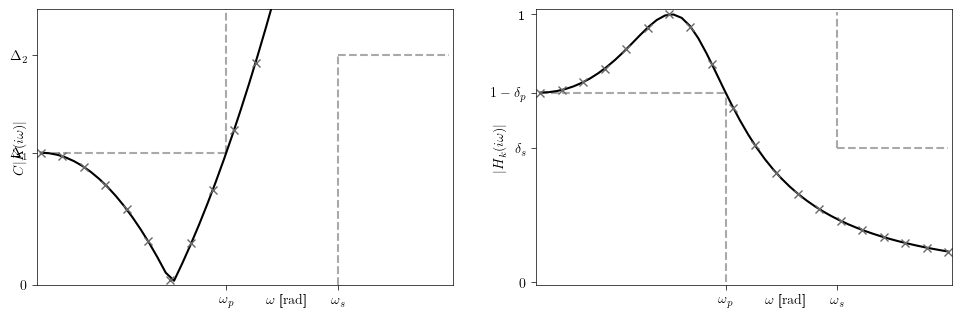

In [130]:
H,C,K,w,dD,dS,wD,wS,n=symbols('H_K C K \\omega \\delta_D \\delta_S \\omega_D \\omega_S n')
_H=1/(1+C**2*abs(K)**2)
display(_H)
wp=w/wD
wps=wS/wD

chebypol=Piecewise((cos(n*acos(wp)),wp<=1),(cosh(n*acosh(wp)),wp>1))
display(chebypol)

D1=sqrt(2*dD-dD**2)/(1-dD)
D2=sqrt(1-dS**2)/dS
n_=acos(D2/D1)/acos(wps) # convert to integer, even order not necessary
n_=ceiling(n_)
cheby=sqrt(_H.subs(K,chebypol).subs(C,D1).subs(n,n_))

display(Eq(symbols('n'),n_))
display(Eq(C*K,D1*abs(chebypol.subs(n,n_))))
display(Eq(H,cheby))



tolp=1-10**(-3/20)#0.1 #durchlassbereich
tols=0.5#sperrbereich
fp=20*2*np.pi
fs=32*2*np.pi
gpass = np.log10(1-tolp)*(-20)
gstop = np.log10(tols)*(-20)


fun=(D1*abs(chebypol.subs(n,n_))).subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs)
fun=lambdify(w,fun)
fmax=2*fs+-fp
omegas = np.linspace(0,fmax)

system = signal.iirdesign(fp, fs, gpass, gstop,analog=True, ftype='cheby1')
omegas_, h = signal.freqs(*system,worN=np.linspace(0,fmax,20))

with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(1,2, figsize=(5.906*2,5.906/1.618))
    axes[0].plot(omegas,fun(omegas),color='k')
    axes[0].plot(omegas_,np.sqrt(1/np.abs(h)**2-1),ls='none',marker='x',color='dimgrey')
    thisD1=float(D1.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
    thisD2=float(D2.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
    ymax=1.2*thisD2
    axes[0].set_ylim((0,ymax))
    axes[0].vlines(fp,thisD1,ymax, color='darkgrey',ls='dashed')
    axes[0].vlines(fs,0,thisD2, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD1,0,fp, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD2,fs,fmax, color='darkgrey',ls='dashed')
    axes[0].set_ylabel('$C|K(i\\omega)|$',labelpad=-12)
    axes[0].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[0].set_xticks([fp,fs])
    axes[0].set_xticklabels(['$\\omega_p$',"$\\omega_s$"])
    axes[0].set_yticks([0,thisD1,thisD2])
    axes[0].set_yticklabels(['$0$','$\\Delta_1$',"$\\Delta_2$"])

    gpass = np.log10(1-tolp)*(-20)
    gstop = np.log10(tols)*(-20)


    fun=(cheby.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
    fun=lambdify(w,fun)

    #fig,ax = plt.subplots()
    axes[1].plot(omegas,fun(omegas),color='k')
    axes[1].plot(omegas_,np.abs(h),ls='none',marker='x',color='dimgrey')
    ymax=axes[1].get_ylim()[1]
    axes[1].vlines(fp,0,(1-tolp), color='darkgrey',ls='dashed')
    axes[1].vlines(fs, tols,ymax, color='darkgrey',ls='dashed')
    axes[1].hlines(1-tolp,0,fp, color='darkgrey',ls='dashed')
    axes[1].hlines(tols,fs,fmax, color='darkgrey',ls='dashed')
    axes[1].set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
    axes[1].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[1].set_xticks([fp,fs])
    axes[1].set_xticklabels(['$\\omega_p$','$\\omega_s$'])
    axes[1].set_yticks([0,tols,1-tolp,1])
    axes[1].set_yticklabels(['$0$','$\\delta_s$',"$1-\\delta_p$",'1'])


order=float(n_.subs(dD,tolp).subs(dS,tols).subs(wD,fp).subs(wS,fs))
display(Eq(symbols('n'),order))
display(Eq(symbols('\\Delta_1'),thisD1))
display(Eq(symbols('\\Delta_2'),thisD2))


order = 31


[Text(0, 0.0, '$0$'),
 Text(0, 0.1, '$\\delta_s$'),
 Text(0, 0.9, '$1-\\delta_p$'),
 Text(0, 1.0, '1')]

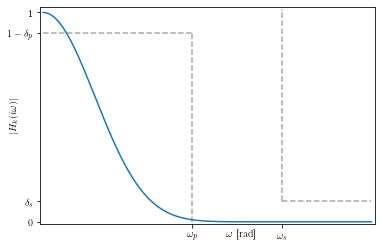

In [149]:




tolp=0.1 #durchlassbereich
tols=0.1#sperrbereich
fp=20*2*np.pi
fs=32*2*np.pi
gpass = np.log10(1-tolp)*(-20)
gstop = np.log10(tols)*(-20)


fmax=2*fs+-fp
omegas = np.linspace(0,fmax,200)

#system = signal.iirdesign(fp, fs, gpass, gstop,analog=True, ftype='ellip')

omegas_, h = signal.freqs(*system, worN=omegas)
print('order =',max(len(system[0]),len(system[1])))

fig,ax = plt.subplots()
ax.plot(omegas_,np.abs(h))
ymax=axes[1].get_ylim()[1]
ax.vlines(fp,0,(1-tolp), color='darkgrey',ls='dashed')
ax.vlines(fs, tols,ymax, color='darkgrey',ls='dashed')
ax.hlines(1-tolp,0,fp, color='darkgrey',ls='dashed')
ax.hlines(tols,fs,fmax, color='darkgrey',ls='dashed')
ax.set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
ax.set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

ax.set_xticks([fp,fs])
ax.set_xticklabels(['$\\omega_p$','$\\omega_s$'])
ax.set_yticks([0,tols,1-tolp,1])
ax.set_yticklabels(['$0$','$\\delta_s$',"$1-\\delta_p$",'1'])

